In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from model.stgcn import flow_stgcn
from model.st_graph import get_distance_adjacency
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

# Load the Le2i Coffe Room and Home

In [3]:
# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'label'])
coffee_falls = np.load('D:\ASH\datasets\Le2i\Coffee_room_all\Skeletons_split_flow\\falls.npy', allow_pickle=True)
coffee_non_falls = np.load('D:\ASH\datasets\Le2i\Coffee_room_all\Skeletons_split_flow\\non_falls.npy', allow_pickle=True)
home_falls = np.load('D:\ASH\datasets\Le2i\Home_all\Skeletons_split_flow\\falls.npy', allow_pickle=True)
home_non_falls = np.load('D:\ASH\datasets\Le2i\Home_all\Skeletons_split_flow\\non_falls.npy', allow_pickle=True)

In [4]:
coffee_falls[0].keys()

dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'label', 'start_frame', 'flows'])

In [5]:
falls = np.concatenate((coffee_falls, home_falls), axis=0)
X_falls_flow = np.array([entry['flows'] for entry in falls])
falls = np.array([entry['keypoints'] for entry in falls])

non_falls = np.concatenate((coffee_non_falls, home_non_falls), axis=0)
X_non_falls_flow = np.array([entry['flows'] for entry in non_falls])
non_falls = np.array([entry['keypoints'] for entry in non_falls])

X_falls = falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

print(X_falls.shape, X_non_falls.shape, X_falls_flow.shape, X_non_falls_flow.shape)

(93, 45, 17, 2) (849, 45, 17, 2) (93, 45, 64) (849, 45, 64)


In [6]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)
# Le2i resolution is 320x240

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
X_falls_flow = np.transpose(X_falls_flow, (0, 2, 1))
X_non_falls_flow = np.transpose(X_non_falls_flow, (0, 2, 1))
print(X_falls.shape, X_non_falls.shape, X_falls_flow.shape, X_non_falls_flow.shape)

(93, 2, 45, 17) (849, 2, 45, 17) (93, 64, 45) (849, 64, 45)


# Initialize the model and dataset object

In [7]:
num_node = 17
A = get_distance_adjacency(np.array(edges), num_node)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
class FlowFallDataset(Dataset):
    def __init__(self, falls, non_falls, falls_flow, non_falls_flow):
        self.falls = falls
        self.non_falls = non_falls
        self.falls_flow = falls_flow
        self.non_falls_flow = non_falls_flow

    def __len__(self):
        # The dataset length is twice the length of the smaller list
        return len(self.falls) + len(self.non_falls)

    def __getitem__(self, idx):
        if idx < len(self.falls):
            return self.falls[idx], self.falls_flow[idx], 1.0
        else:
            return self.non_falls[idx - len(self.falls)], self.non_falls_flow[idx - len(self.falls)], 0.0

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset):
        self.num_falls = len(dataset.falls)
        self.num_non_falls = len(dataset.non_falls)
        self.data_size = self.num_falls + self.num_non_falls
        self.batch_size = 2 * self.num_falls

    def __iter__(self):
        # Create an array of indices representing balanced classes
        non_fall_indices = np.arange(self.num_non_falls)
        np.random.shuffle(non_fall_indices)  # Shuffle the indices to have random batches
        batch = np.arange(self.num_falls).tolist()
        for idx in non_fall_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = np.arange(self.num_falls).tolist()
        if len(batch) > 0:  # Yield remaining items not fitting into a full batch
            yield batch

    def __len__(self):
        return (self.data_size + self.batch_size - 1) // self.batch_size

def evaluate(model, loader, print_acc=False):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    acc, loss = 0.0, 0.0
    for X_batch, flow_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        flow_batch = flow_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)
        with torch.no_grad():
            y_pred = model(X_batch, flow_batch)
            loss += loss_func(y_pred, y_batch).detach().cpu().item()
            acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
            
    loss /= len(loader.dataset)
    acc /= len(loader.dataset)
    return loss, acc

In [10]:
falls_train, falls_valid = train_test_split(X_falls, test_size=0.2, random_state=217)
falls_flow_train, falls_flow_valid = train_test_split(X_falls_flow, test_size=0.2, random_state=217)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid), random_state=217)
non_falls_flow_train, non_falls_flow_valid = train_test_split(X_non_falls_flow, test_size=len(falls_valid), random_state=217)
training_set = FlowFallDataset(falls=falls_train, non_falls=non_falls_train, falls_flow=falls_flow_train, non_falls_flow=non_falls_flow_train)
validation_set = FlowFallDataset(falls=falls_valid, non_falls=non_falls_valid, falls_flow=falls_flow_valid, non_falls_flow=non_falls_flow_valid)

In [11]:
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

In [12]:
skeleton, flow, label = next(iter(training_loader))

In [15]:
layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
model = None
model = flow_stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_mask=True, flow_norm=True)
model.to(device)

flow_stgcn(
  (flows_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stgcn_in): Sequential(
    (0): unit_sgcn(
      (conv_nets): ModuleList(
        (0-1): 2 x Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
    (1): unit_tgcn(
      (conv_net): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
  )
  (layers): ModuleList(
    (0-2): 3 x stgcn_unit(
      (sgcn): unit_sgcn(
        (conv_nets): ModuleList(
          (0-2): 3 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (non_linearity): ReLU()
      )
      (tgcn): unit_tgcn(
        (conv_net): Conv2d(6

# Training loop

Training Loss: 0.0040: 100%|██████████| 35/35 [01:41<00:00,  2.89s/it]


Training loss: 0.003975613487769017
Validation loss: 0.008908201989374663
Training accuracy: 0.9767699115044248
Validation accuracy: 0.9736842105263158


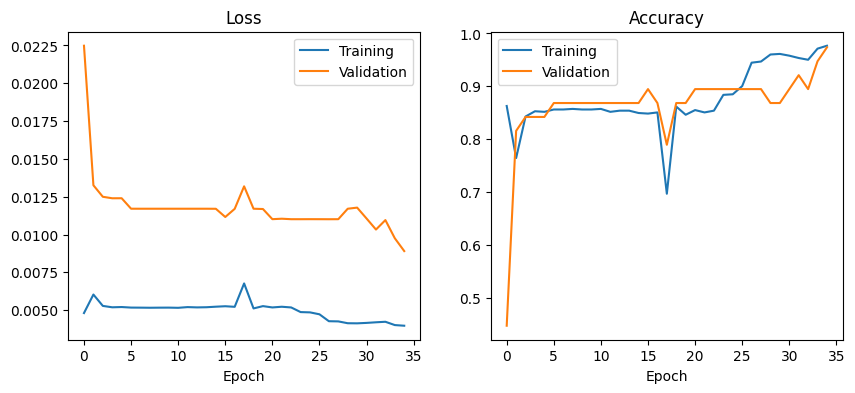

In [16]:
epochs = 35
lr = 0.0015
weight_decay = 0
batch_size = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    for X_batch, flow_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        flow_batch = flow_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch, flow_batch)
        batch_loss = loss_func(y_pred, y_batch)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    # scheduler.step()

    train_loss, train_acc = evaluate(model, train_eval_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

In [17]:
torch.save(model.state_dict(), '.\model_weights\le2i_flow_97acc.pth')